### (on going project)

## Background

Pneumonia is a form of acute respiratory tract infection that affect the lungs. In 2017, pneumonia killed as many as 808 694 children under the age of 5, accounting for 15% of deaths among children under 5 years of age. Pneumonia can affect people of any age, but children and the elderly, and people with pre-existent health problems are at the most risk of invasive pneumococcal disease (IPD), which is a form of pneumonia where the bacterium *S. pneumoniae* enters the blood. Pneumonia kills more children under five than AIDS, malaria and measles combined. Yet increased attention has been given to the latter diseases.

&nbsp;


### Types of Pneumonia

There are more than 30 different causes of pneumonia, but the most common are bacteria and viruses. 

&nbsp;

### Diagnosis of Pneumonia

It is difficult to differentiate between virial and bacterial pneumonia in resource-poor settings lacking in technology and laboratory equipment

&nbsp;

## Objective

In this work, we are going to train a CNN (Convolutional Neural Network) in order to classify three classes of chest x-ray images, namely chest x-ray of healh lungs, and lungs affected by bacterial and viral types of pneumonia. We will be using Pytorch as our Deep Learning framework. The network architecture consists of a block of pretrained VGG16 convolutional layers, followed by a block of random initialized convolutional layers. The features learned by the convolutional layers are then passed through a stack of fully connected layers, which output raw unnormalized scores. The loss is computed using the [`CrossEntropyLoss()`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) class provided by Pytorch, which combines [`nn.LogSoftmax()`](https://pytorch.org/docs/master/generated/torch.nn.LogSoftmax.html) and `nn.NLLLoss()` in one single class. We also use dropout layers as regularizers and one batch normalization layer. We then evaluate weighted Recall, Precion and F1-Score metrics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Pytorch imports
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import (DataLoader,
                              Dataset,
                              TensorDataset)

from torch.optim import Adam, RMSprop, SGD
from torchvision import transforms
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.transforms.functional as TF

# Albumentations imports
from albumentations.pytorch import ToTensor
import albumentations as A

# Sklearn metrics imports 
from sklearn.metrics import (f1_score, 
                             recall_score,
                             balanced_accuracy_score,
                             precision_score, 
                             roc_auc_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

# For showing the confusion matrix
from mlxtend.plotting import plot_confusion_matrix

# Other imports
import cv2
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join
import joblib
from collections import Counter
import pandas as pd
import seaborn as sns
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading the Data

In [0]:
def get_data_dict():
    data_dict = {}
    for path in PATHS:
        for filetype in FILETYPE:
            for filename in (filename for filename in os.listdir(join(path, filetype)) if '.jpeg' in filename):
                image = cv2.imread(join(path, filetype, filename))
                image = np.dstack([image]*3) if image.ndim==2 else image
                resized = cv2.resize(image, (224, 224))
                data_dict[filename] = resized
    return data_dict
data = get_data_dict()

In [0]:
data = joblib.load('/content/drive/My Drive/data/data_dict.joblib')

In [0]:
class_normal = np.array([data[key] for key, value in data.items() if ('bacteria' or 'virus') not in key])
class_bacteria = np.array([data[key] for key, value in data.items() if 'bacteria' in key])
class_virus = np.array([data[key] for key, value in data.items() if 'virus' in key])

# Downsample normal cases
class_normal = class_normal[:len(class_virus)+300]

targets = [0] * len(class_normal)
targets.extend([1] * len(class_bacteria))
targets.extend([2] * len(class_virus))

X_data, y_true = np.vstack([class_normal, class_bacteria, class_virus]), np.array(targets)

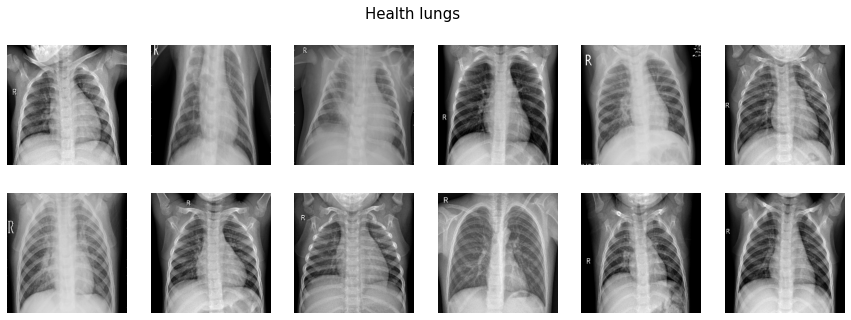

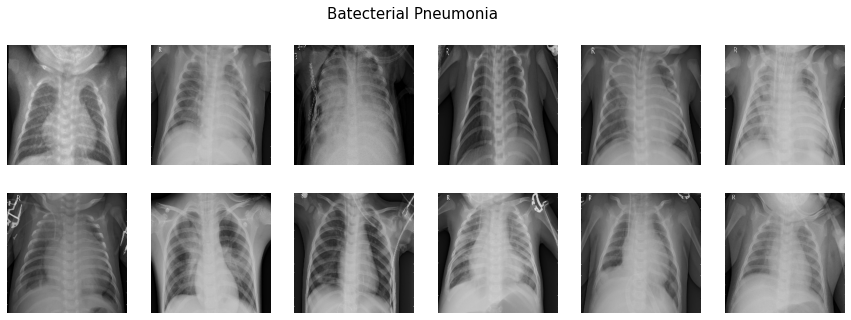

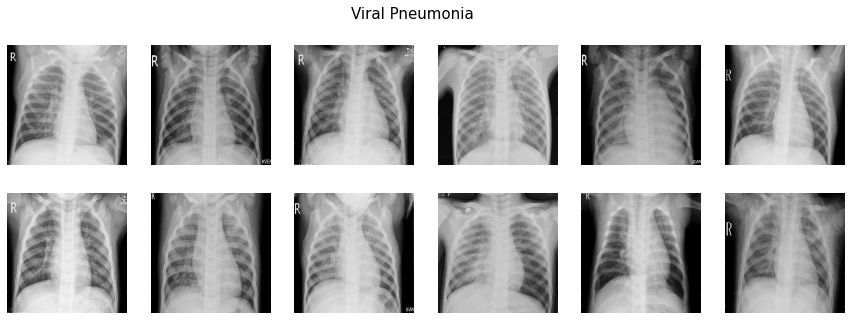

In [0]:
def visualize_samples(images, rows=1, cols=5, title=None):
    plt.figure(figsize=(2.5*cols, 2.5*rows)).suptitle(title, size=15, color='black')
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, sample in enumerate(images[idx]):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
    plt.show()

visualize_samples(X_data[y_true==0], rows=2, cols=6, title='Health lungs')
visualize_samples(X_data[y_true==1], rows=2, cols=6, title='Batecterial Pneumonia')
visualize_samples(X_data[y_true==2], rows=2, cols=6, title='Viral Pneumonia')

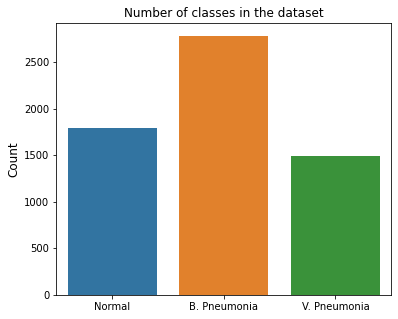

In [0]:
plt.figure(figsize=(6, 5))
sns.barplot(x=['Normal', 'B. Pneumonia', 'V. Pneumonia'], 
                y=list(Counter(y_true).values()))
plt.title("Number of classes in the dataset")
plt.ylabel("Count", size=12)
plt.show()

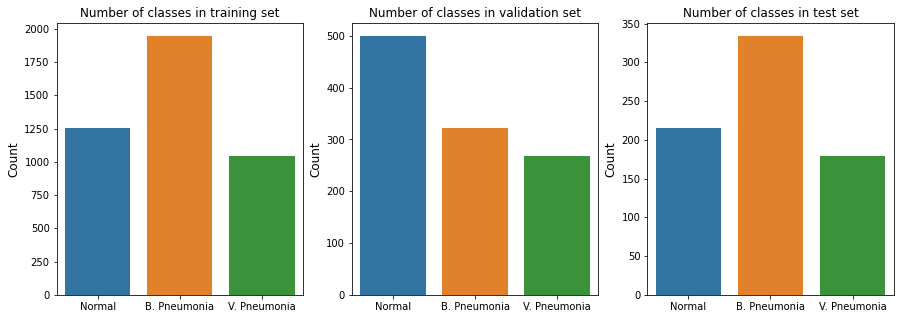

In [50]:
X_train, X_, y_train, y_ = train_test_split(X_data, y_true, test_size=.3, random_state=1, stratify=y_true)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=.4, random_state=1, stratify=y_)

plt.figure(figsize=(15, 5))
for i, (labels, set_name) in enumerate(zip([y_train, y_val, y_test], ['training', 'validation', 'test'])):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=['Normal', 'B. Pneumonia', 'V. Pneumonia'], 
                y=list(Counter(labels).values()))
    plt.title("Number of classes in {} set".format(set_name), size=12)
    plt.ylabel("Count", size=12)
plt.show()

## Augmentation Pipeline

In [0]:
aug_pipeline = A.Compose([
                     A.OneOf([
                              A.ShiftScaleRotate(shift_limit=0, rotate_limit=0, p=1.0),
                              A.VerticalFlip(p=1.0),
                              A.RandomRotate90(p=1.0),
                              A.OpticalDistortion(p=1.0),
                              A.GridDistortion(p=1.0)
                              ], p=.6),
                     ToTensor(),
                     ])

## Batch Preparation

In [0]:
# Declaring custom Pytorch Dataset subclasses

class TrainDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform 
  
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = torch.tensor(self.labels[index], dtype=torch.long)
        if self.transform is not None:
            image = self.transform(image=self.images[index])['image']
        else:
            image = TF.to_tensor(self.images[index])
        return image, target
        
        
class ValDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
  
    def __getitem__(self, index):
        image = TF.to_tensor(self.images[index])
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target
    
    
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = TF.to_tensor(self.images[index])
        return image.to(device)

In [0]:
def weighted_random_sampler(targets):
    class_counts = list(Counter(targets).values())
    weights = 1. / torch.FloatTensor(class_counts)
    samples_weights = weights[targets]
    sampler = WeightedRandomSampler(weights=samples_weights, 
                                    num_samples=len(samples_weights),
                                    replacement=True)
    return sampler

In [0]:
traindata_params = dict(batch_size=32,
                        num_workers=6,
                        shuffle=False,
                        pin_memory=False)

valdata_params = dict(batch_size=64,
                      num_workers=6,
                      shuffle=False,
                      pin_memory=False)

testdata_params = dict(batch_size=1, 
                       shuffle=False, 
                       pin_memory=False)


# Sampling strategy to preserve class weights in each mini-batch
train_sampler = weighted_random_sampler(y_train)
val_sampler = weighted_random_sampler(y_val)

# Creating DataLoaders for training, validation and test sets.
train_data = TrainDataset(images=X_train, labels=y_train, transform=aug_pipeline)
train_loader = DataLoader(train_data, **traindata_params, sampler=train_sampler)

val_data = ValDataset(images=X_val, labels=y_val)
val_loader = DataLoader(val_data, **valdata_params, sampler=val_sampler)

test_dataset = TestDataset(images=X_test)
test_loader = DataLoader(test_dataset, **testdata_params)

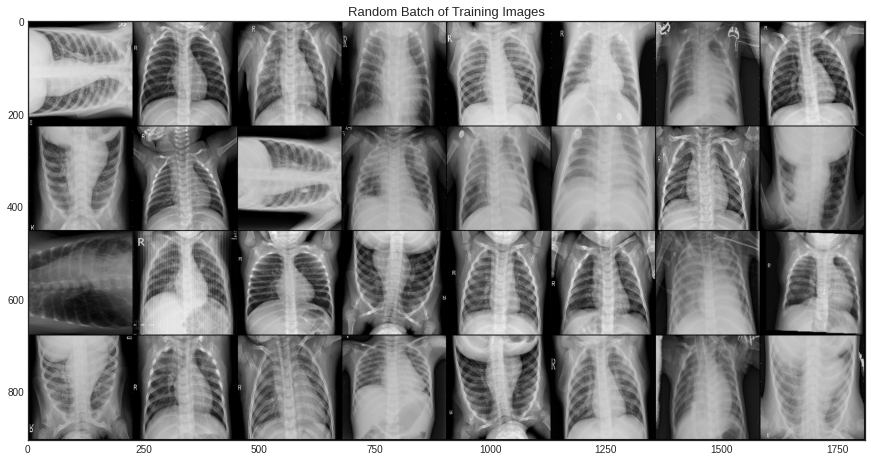

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(15, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Random Batch of Training Images", size=13)
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Model Definition

In [0]:
model_vgg16 = torchvision.models.vgg16(pretrained=True)
for params in model_vgg16.parameters():
    params.requires_grad = False
pretrained_convs = list(model_vgg16.features)[:7]

In [0]:
class Network(nn.Module):
    def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
       *pretrained_convs,
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 128, 3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, 3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2)
    )
    
    self.fc_layers = nn.Sequential(
        nn.Dropout(p=0.6),
        nn.Linear(36864, 324),
        nn.ReLU(),
        nn.Dropout(p=.4),
        nn.Linear(324, 3)
      )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

In [0]:
model = Network().to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

## Model Fitting

In [0]:
def visualize_eval(train_loss, val_loss) :
    plt.figure(figsize=(5, 5))
    epochs = range(1, 1 + len(train_loss)) 
    plt.style.use('seaborn-white')
    plt.plot(epochs, train_loss, color='blue', label='Train loss')
    plt.plot(epochs, val_loss, color='orange', label='Valdation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [0]:
def fit(model, train_loader=None, val_loader=None, epochs=15):
    torch.manual_seed(0)
    train_loss = []
    val_loss = []
    validation_loss_epoch = 0.0

    for epoch in range(1, epochs+1):
        print('\nEpoch {}/{}'.format(epoch, epochs))
        training_loss = []
        validation_loss = []
        val_loss_epoch = validation_loss_epoch

        model.train()
        for batch_x, batch_y in tqdm(train_loader):
            train_x, train_y = batch_x.to(device), batch_y.to(device)
            outputs = model(train_x) # forward propagation
            loss = criterion(outputs, train_y) # compute the loss
            training_loss.append(loss.item())
            loss.backward() # backpropagation 
            optimizer.step() # optimization step
            optimizer.zero_grad() # set parameter gradients to zero

        with torch.no_grad():
            model.eval()
            for val_batch_x, val_batch_y in val_loader:
                val_x, val_y = val_batch_x.to(device), val_batch_y.to(device)
                val_outputs = model(val_x)
                loss_val = criterion(val_outputs, val_y)
                validation_loss.append(loss_val.item())

        training_loss_epoch = np.mean(training_loss)
        validation_loss_epoch = np.mean(validation_loss)

        if validation_loss_epoch < val_loss_epoch:
            best_weights = deepcopy(model.state_dict())

        train_loss.append(training_loss_epoch)
        val_loss.append(validation_loss_epoch)
        print('\ttrain_loss: %.4f\t\n' % training_loss_epoch, '\tval_loss: %.4f\t' % validation_loss_epoch)
    visualize_eval(train_loss, val_loss)
    return best_weights


Epoch 1/10



	train_loss: 0.8656	
 	val_loss: 0.6838	

Epoch 2/10



	train_loss: 0.7528	
 	val_loss: 0.7373	

Epoch 3/10



	train_loss: 0.7046	
 	val_loss: 0.7190	

Epoch 4/10



	train_loss: 0.6853	
 	val_loss: 0.7035	

Epoch 5/10



	train_loss: 0.6685	
 	val_loss: 0.6919	

Epoch 6/10



	train_loss: 0.6713	
 	val_loss: 0.7039	

Epoch 7/10



	train_loss: 0.6350	
 	val_loss: 0.6382	

Epoch 8/10



	train_loss: 0.6490	
 	val_loss: 0.6436	

Epoch 9/10



	train_loss: 0.6288	
 	val_loss: 0.6684	

Epoch 10/10



	train_loss: 0.6273	
 	val_loss: 0.6273	


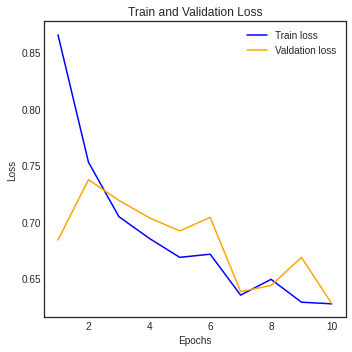

In [195]:
best_weights = fit(model, 
                   train_loader, 
                   val_loader, 
                   epochs=15)

In [171]:
model.load_state_dict(best_weights)

<All keys matched successfully>

## Evaluation

In [0]:
model.eval()
test_outputs = torch.zeros((len(X_test), 3), dtype=torch.float, device=device)
with torch.no_grad():
    for i, test_batch_x in enumerate(test_loader):
        outputs = test_batch_x.to(device)
        test_outputs[i] = model(outputs)

_, predicted = torch.max(test_outputs, 1)
pred_classes = predicted.to('cpu').detach().numpy()

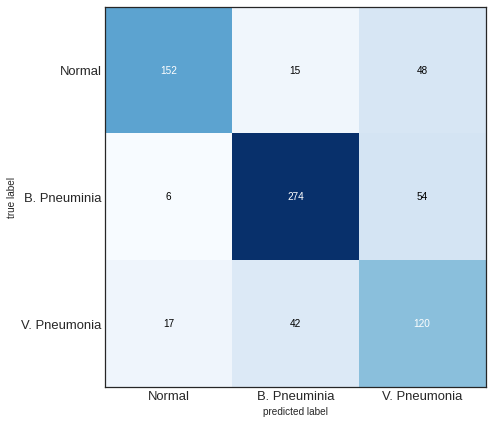

In [201]:
cm  = confusion_matrix(y_test, pred_classes)
plot_confusion_matrix(cm,figsize=(12, 7), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'B. Pneuminia', "V. Pneumonia"], fontsize=13)
plt.yticks(range(3), ['Normal', 'B. Pneuminia', "V. Pneumonia"], fontsize=13)
plt.show()

In [202]:
f1score = f1_score(y_test, pred_classes, average='weighted')
rec = recall_score(y_test, pred_classes, average='weighted')
pre = precision_score(y_test, pred_classes, average='weighted') 
scores = [f1score, rec, pre]

print("Weighted F1-Score --> %.1f%%" % (f1score * 100))
print("Weighted Recall --> %.1f%%" % (rec * 100))
print("Weighted Precision --> %.1f%%" % (pre * 100))

Weighted F1-Score --> 75.5%
Weighted Recall --> 75.0%
Weighted Precision --> 76.9%
